# Ahmed Ayman

# Decision Tree Algorithm

**The decision tree Algorithm belongs to the family of supervised machine learning algorithms. It can be used for both a classification problem as well as for regression problem.**
**The goal of this algorithm is to create a model that predicts the value of a target variable, for which the decision tree uses the tree representation to solve the problem in which the leaf node corresponds to a class label and attributes are represented on the internal node of the tree.**

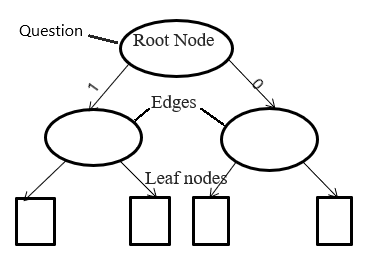

# Entropy

**Entropy is the measures of impurity, disorder or uncertainty in a bunch of examples.**

**Entropy controls how a Decision Tree decides to split the data. It actually effects how a Decision Tree draws its boundaries.**

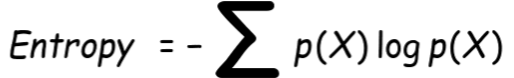

# Information Gain (IG)


**Information gain (IG) measures how much “information” a feature gives us about the class.**
* Information gain is the main key that is used by Decision Tree Algorithms to construct a Decision Tree.
* Decision Trees algorithm will always tries to maximize Information gain.
* An attribute with highest Information gain will tested/split first.

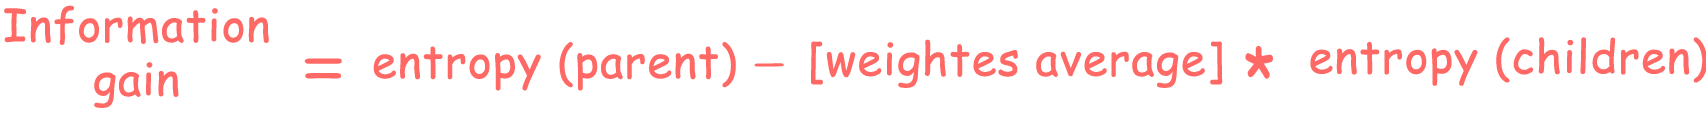

# Import Libaries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split,KFold
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,classification_report
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from collections import Counter,defaultdict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pydotplus

# Import Data

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target
df = pd.DataFrame(X,columns=data['feature_names'])
df['class'] = y

# Visualization visual inspection of Dataset

In [3]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
#Describe dataset
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [ ]:
#get info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [ ]:
df['class'].unique()

array([0, 1])

In [ ]:
#Check if dataset is balanced
df.groupby('class').size()

class
0    212
1    357
dtype: int64

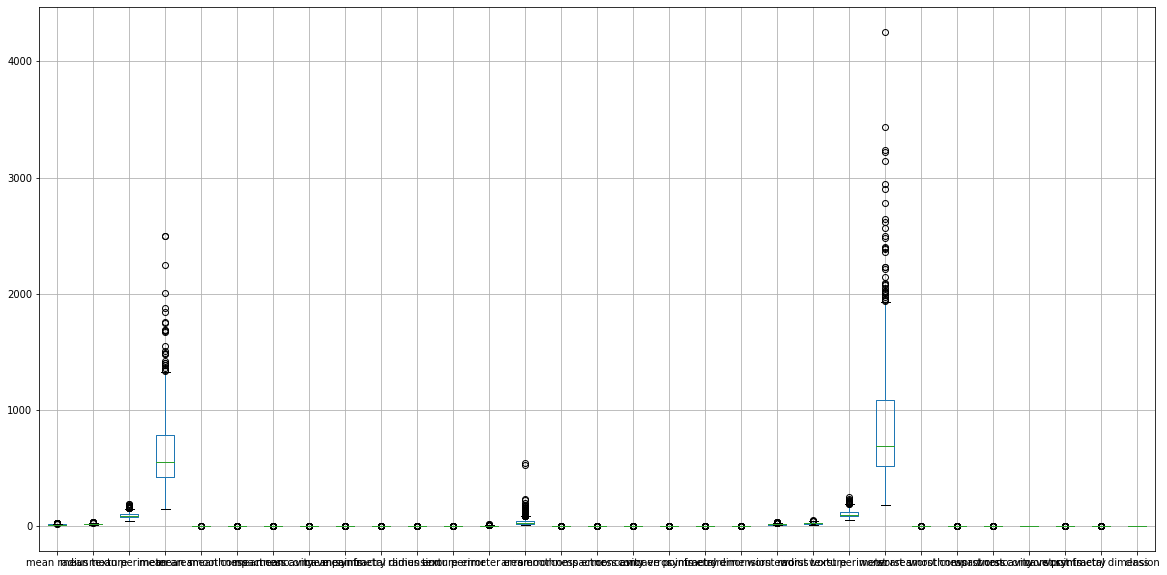

In [ ]:
#Box Plot for each input variable
pd.plotting.boxplot_frame(df,figsize=(20,40))


In [ ]:
Rscaler = RobustScaler()
A = Rscaler.fit_transform(X)

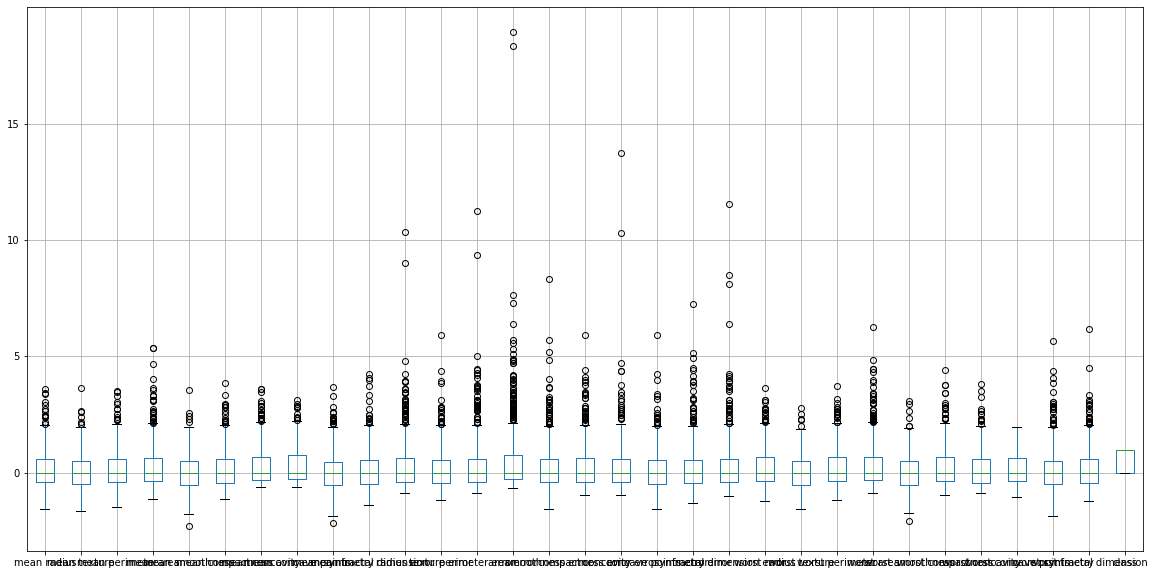

In [ ]:
df2 = pd.DataFrame(A,columns=data['feature_names'])
df2['class'] = y
df2

#Box Plot for each input variable
pd.plotting.boxplot_frame(df2,figsize=(20,10)) # Make it Worest

In [ ]:
Z=df[df.columns.difference(['class'])]
target=pd.factorize(df['class'])[0]
sns.pairplot(data = Z)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
Z=df[df.columns.difference(['class'])]
target=pd.factorize(df['class'])[0]

#scatter Plot for two input variables

pd.plotting.scatter_matrix(Z,figsize=(40,50),marker='o',hist_kwds={'bins':20},s=60,alpha=.8,c=target)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

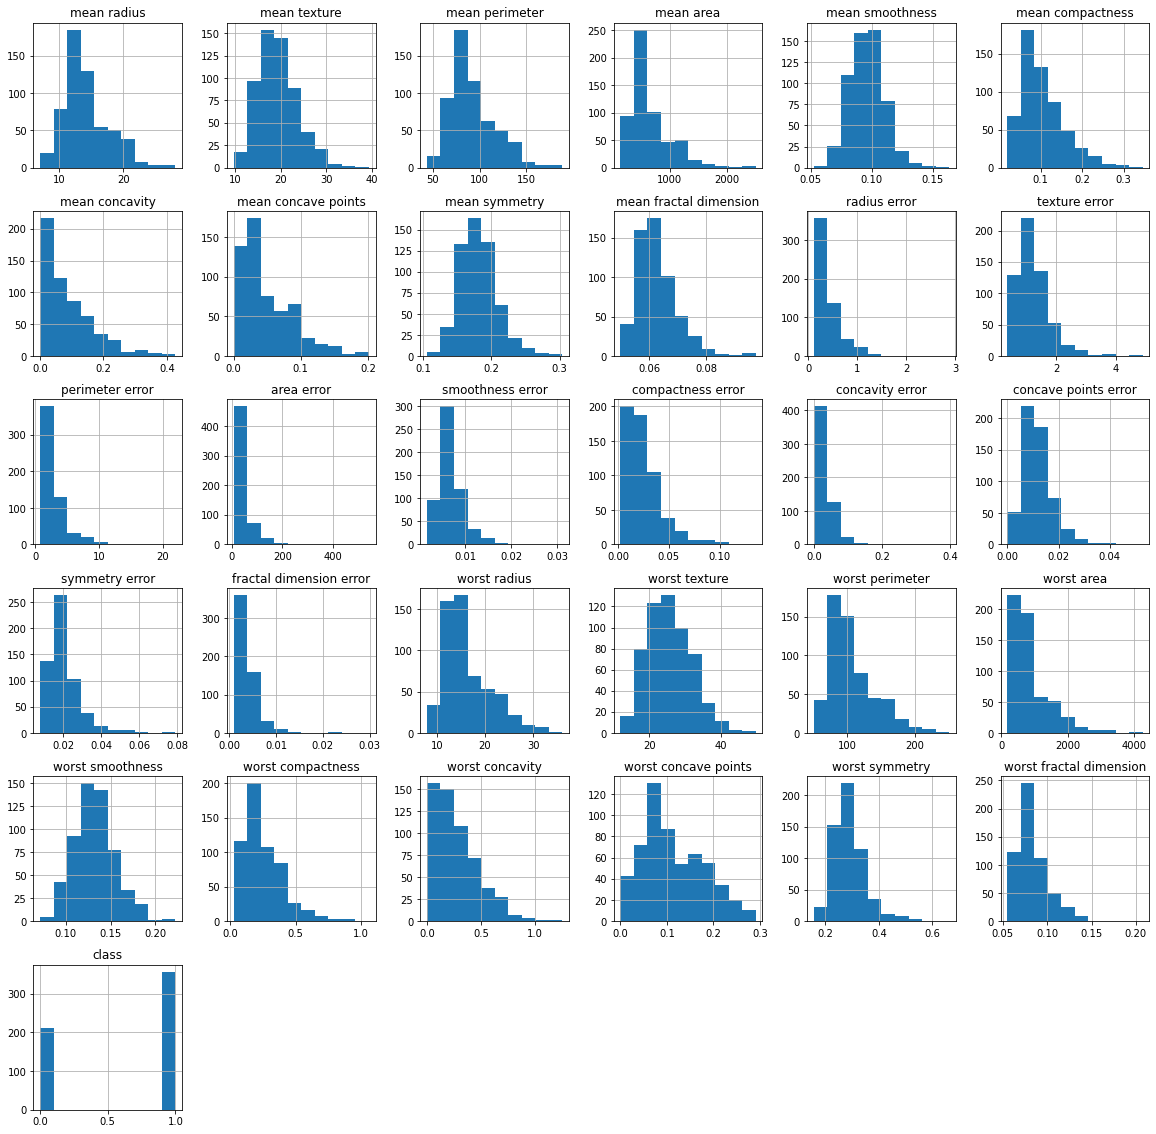

In [ ]:
#Histogram Plot for each input variable

pd.plotting.hist_frame(df,figsize=(20,20))
plt.show()

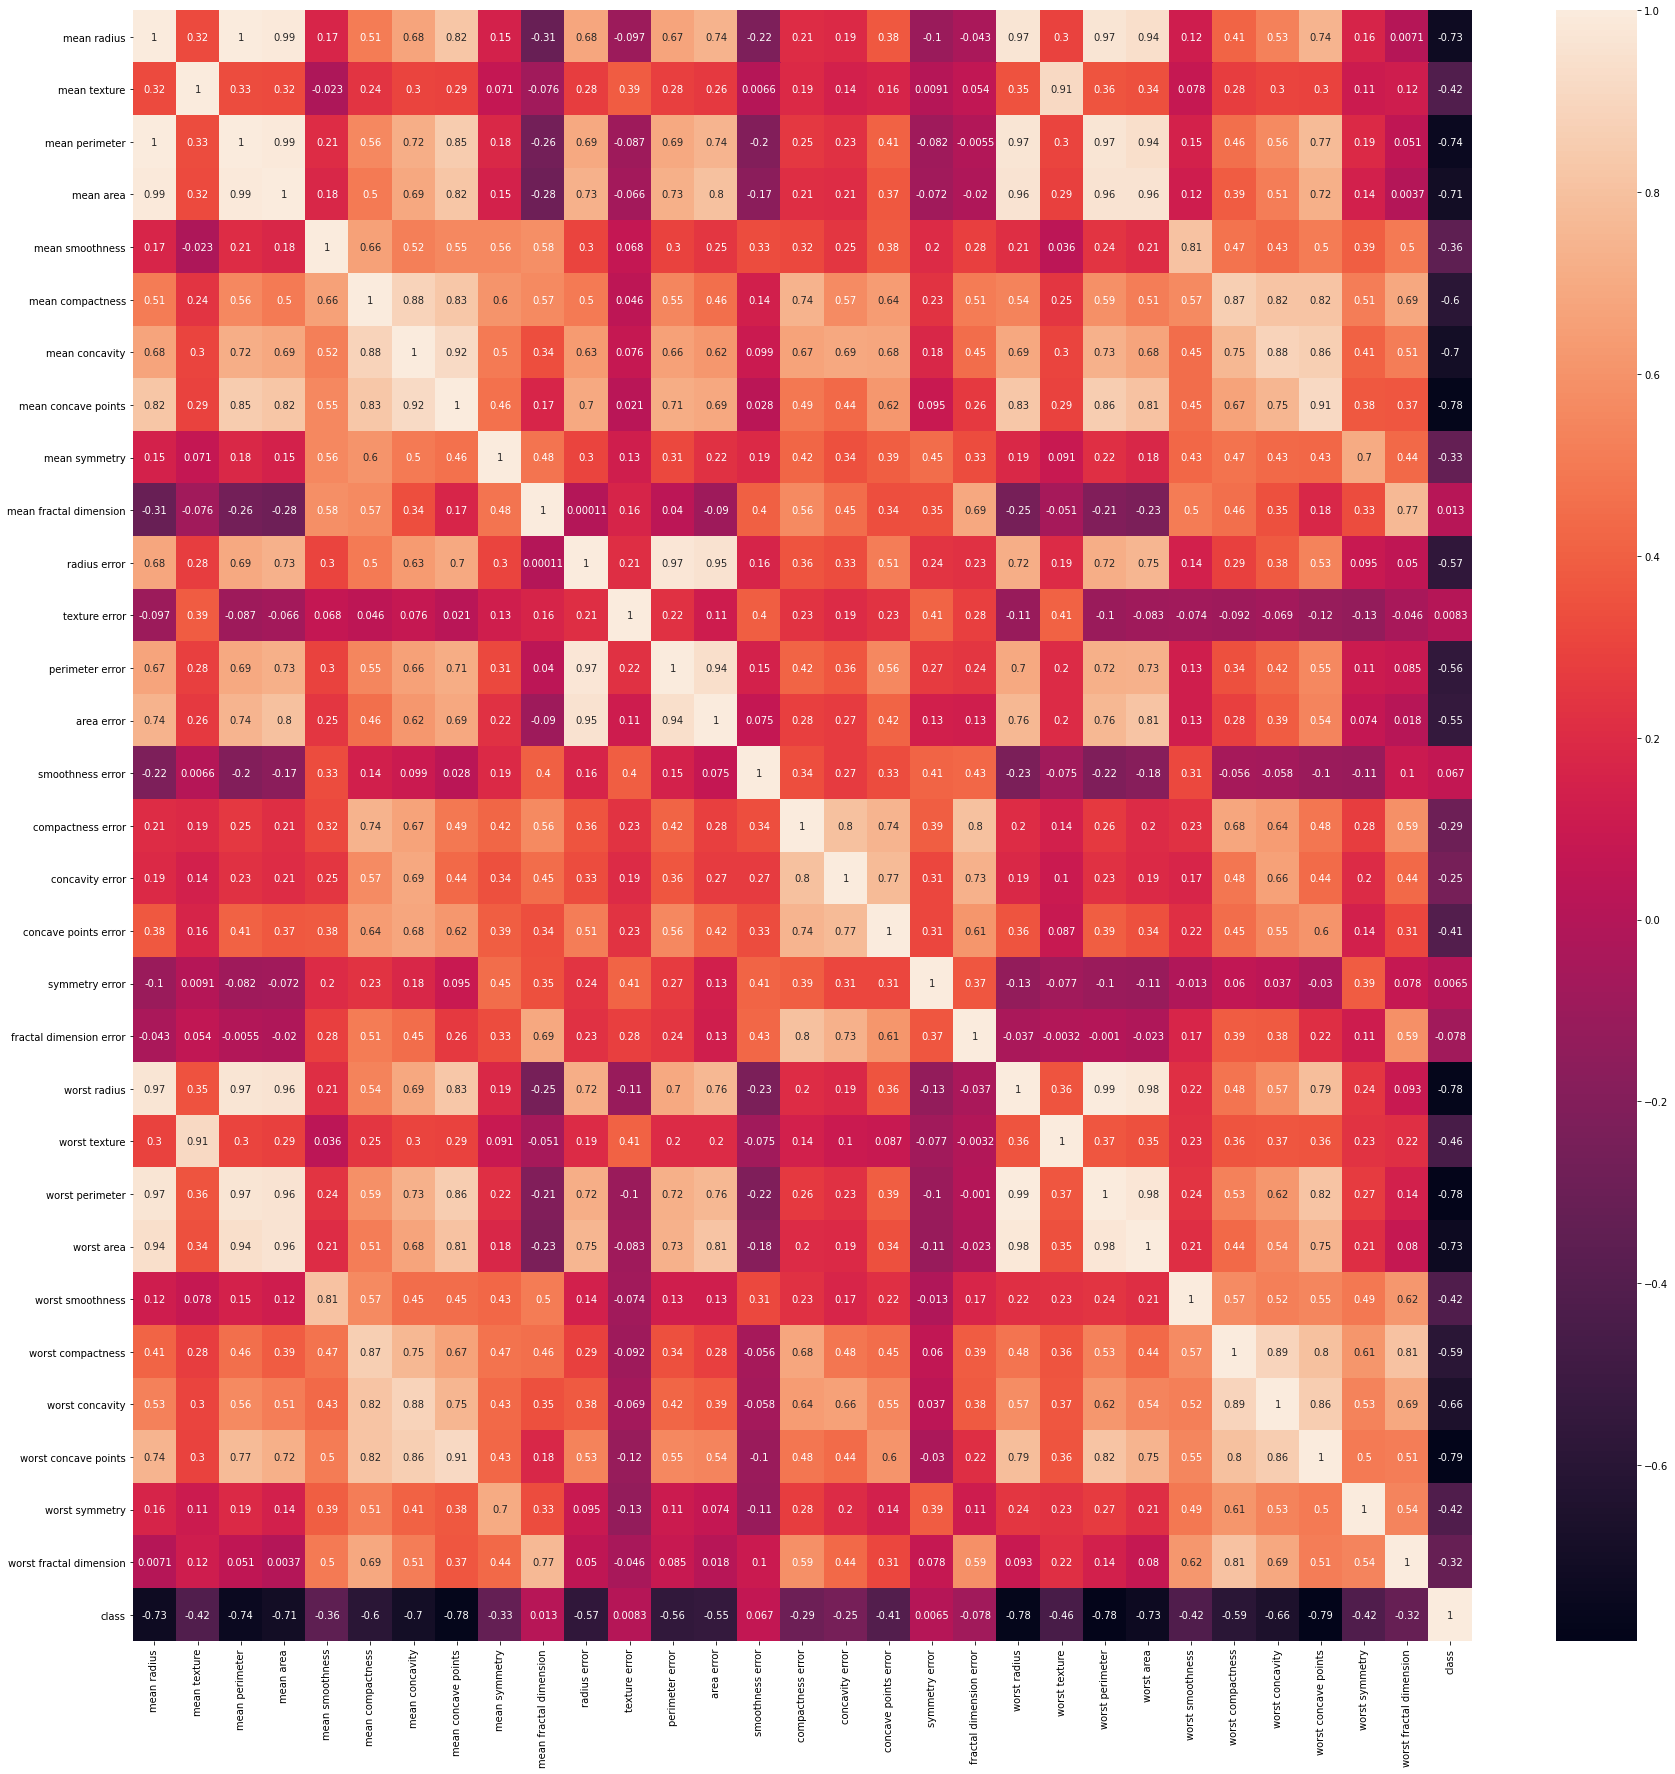

In [ ]:
corr=df.corr()
fig, ax = plt.subplots(figsize=(30,30)) 
sns.heatmap(corr, annot = True,ax=ax)
plt.show()

# Impilimintaion From [link text](https://github.com/python-engineer/MLfromscratch/blob/master/mlfromscratch/decision_tree.py)

In [ ]:
def entropy(y):  #Entropy is the measures of impurity, disorder, or uncertainty in a bunch of examples.
    hist = np.bincount(y) #Count number of occurrences of each value in array of non-negative ints
    ps = hist / len(y) #probability of each y in Y
    return -np.sum([p * np.log2(p) for p in ps if p > 0])   #Entropy controls how a Decision Tree decides to split the data. It affects how a Decision Tree draws its boundaries.


class Node: #To store the Nodes information
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None # Keyword only parameter
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None  #If it have a value then it's a leaf node else it's not leaf node


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None #where to start traversing the tree

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1]) #num of futuers = n_feats if n_feats < len(x) else num of futuers = len(x)
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False) #Select Random Features

        # greedily select the best split according to information gain
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        # grow the children that result from the split
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1) #Call the function until it reach max depth
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1) #Call the function until it reach max depth
        return Node(best_feat, best_thresh, left, right) #store the Nodes information

    def _best_criteria(self, X, y, feat_idxs): #go over all the features and all the feature values and calculate the information gain
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds: # go over all possible thresholds
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh): #Information gain(IG) measures how much “information” a feature gives us about the class.
        # parent E 
        parent_entropy = entropy(y)

        # generate split
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # compute the weighted avg. of the loss for the children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh): #Splet the Data based on threshold
        left_idxs = np.argwhere(X_column <= split_thresh).flatten() #Return 1D array where X <= split_thresh
        right_idxs = np.argwhere(X_column > split_thresh).flatten() #Return 1D array where X > split_thresh
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node(): #If Reach a leaf Node
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y): #Calculate the number of occurrences for all y's
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common


# Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Data Scale

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train implemented model

In [ ]:
clf = DecisionTree(max_depth=2)
clf.fit(X_train, y_train)
train_pred = clf.predict(X_train)


In [ ]:
train_pred = clf.predict(X_train)
print ( 'Train Accuracy score: %.20f' %accuracy_score ( y_train, train_pred ) )
print ( 'Train Roc_Auc score: %.20f' %roc_auc_score ( y_train, train_pred ) )
confusion_matrix(y_train, train_pred)

Train Accuracy score: 0.92967032967032969815
Train Roc_Auc score: 0.93941284098469723940


array([[163,   4],
       [ 28, 260]])

In [ ]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       167
           1       0.98      0.90      0.94       288

    accuracy                           0.93       455
   macro avg       0.92      0.94      0.93       455
weighted avg       0.94      0.93      0.93       455



# Test implemented model

In [ ]:
y_pred = clf.predict(X_test)
print ( 'Test Accuracy score: %.20f' %accuracy_score ( y_test, y_pred ) )
print ( 'Test Roc_Auc score: %.20f' %roc_auc_score ( y_test, y_pred ) )
confusion_matrix(y_test, y_pred)

Test Accuracy score: 0.90350877192982459452
Test Roc_Auc score: 0.90869565217391301548


array([[42,  3],
       [ 8, 61]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        45
           1       0.95      0.88      0.92        69

    accuracy                           0.90       114
   macro avg       0.90      0.91      0.90       114
weighted avg       0.91      0.90      0.90       114



# Cross ValiValidation with K_Fold

In [ ]:
DC = DecisionTree()
max_dep = [2,5,10,15,20]
best_score = 0
best_param = 0
kf = KFold(n_splits=4)
j = 1
for train_index, test_index in kf.split(X_train):
    fx_train, fx_test = X_train[train_index], X_train[test_index]
    fy_train, fy_test = y_train[train_index], y_train[test_index]
    print(f'{j}th Fold')
    j+=1
    for i in max_dep :
      DC.max_depth = i 
      DC.fit(fx_train, fy_train)
      ftrain_pred = DC.predict(fx_test)
      acu = roc_auc_score ( fy_test, ftrain_pred )
      if acu > best_score:
        best_score = acu
        best_param = i
      print ( f'Test Roc_Auc score {acu} For i = {i} ' )

print('#'*20)
print ( f'Best Roc_Auc score {best_score} For i = {best_param} ' )

1th Fold
Test Roc_Auc score 0.9215384615384615 For i = 2 
Test Roc_Auc score 0.9082051282051283 For i = 5 
Test Roc_Auc score 0.9020512820512822 For i = 10 
Test Roc_Auc score 0.9020512820512822 For i = 15 
Test Roc_Auc score 0.8892307692307693 For i = 20 
2th Fold
Test Roc_Auc score 0.9206349206349206 For i = 2 
Test Roc_Auc score 0.9365079365079365 For i = 5 
Test Roc_Auc score 0.9365079365079365 For i = 10 
Test Roc_Auc score 0.9365079365079365 For i = 15 
Test Roc_Auc score 0.943452380952381 For i = 20 
3th Fold
Test Roc_Auc score 0.9485751719620047 For i = 2 
Test Roc_Auc score 0.9369472649852605 For i = 5 
Test Roc_Auc score 0.9415329184408779 For i = 10 
Test Roc_Auc score 0.9369472649852605 For i = 15 
Test Roc_Auc score 0.9556174254831314 For i = 20 
4th Fold
Test Roc_Auc score 0.8963455149501661 For i = 2 
Test Roc_Auc score 0.8990033222591362 For i = 5 
Test Roc_Auc score 0.9132890365448505 For i = 10 
Test Roc_Auc score 0.8757475083056477 For i = 15 
Test Roc_Auc score 0.87

# SKLearn

In [ ]:
DT = DecisionTreeClassifier(max_depth = 2)

DT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
train_pr = DT.predict(X_train)
print ( 'Train Accuracy score: %.20f' %accuracy_score ( y_train, train_pr ) )
print ( 'Train Roc_Auc score: %.20f' %roc_auc_score ( y_train, train_pr ) )
confusion_matrix(y_train, train_pr)
print(classification_report(y_train, train_pr))

Train Accuracy score: 0.96483516483516484907
Train Roc_Auc score: 0.95964321357285420344
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       167
           1       0.97      0.98      0.97       288

    accuracy                           0.96       455
   macro avg       0.96      0.96      0.96       455
weighted avg       0.96      0.96      0.96       455



In [ ]:
Y_pred = DT.predict(X_test)
print ( 'Test Accuracy score: %.20f' %accuracy_score ( y_test, Y_pred ) )
print ( 'Test Roc_Auc score: %.20f' %roc_auc_score ( y_test, Y_pred ) )
confusion_matrix(y_test, Y_pred)
print(classification_report(y_test, Y_pred))

Test Accuracy score: 0.91228070175438591427
Test Roc_Auc score: 0.90048309178743957126
              precision    recall  f1-score   support

           0       0.93      0.84      0.88        45
           1       0.90      0.96      0.93        69

    accuracy                           0.91       114
   macro avg       0.92      0.90      0.91       114
weighted avg       0.91      0.91      0.91       114



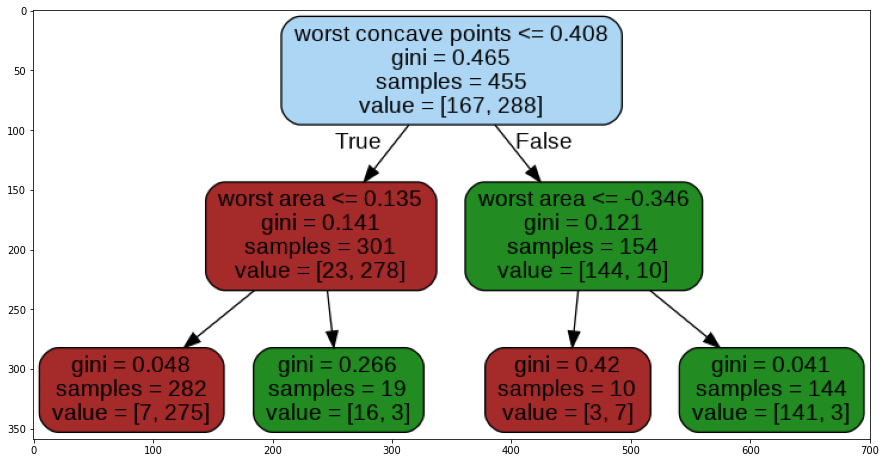

In [ ]:
dot_data = export_graphviz(DT,
                                feature_names=data.feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('brown', 'forestgreen')
edges = defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')
img = mpimg.imread('tree.png')
fig = plt.figure(figsize=(15,10))
plt.imshow(img)

# Cause an overfitting to the model!

# Train implemented model

In [ ]:
clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
train_pred = clf.predict(X_train)


In [ ]:
train_pred = clf.predict(X_train)
print ( 'Train Accuracy score: %.20f' %accuracy_score ( y_train, train_pred ) )
print ( 'Train Roc_Auc score: %.20f' %roc_auc_score ( y_train, train_pred ) )
confusion_matrix(y_train, train_pred)

Train Accuracy score: 1.00000000000000000000
Train Roc_Auc score: 1.00000000000000000000


array([[167,   0],
       [  0, 288]])

In [ ]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       288

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455



# Test implemented model

In [ ]:
y_pred = clf.predict(X_test)
print ( 'Test Accuracy score: %.20f' %accuracy_score ( y_test, y_pred ) )
print ( 'Test Roc_Auc score: %.20f' %roc_auc_score ( y_test, y_pred ) )
confusion_matrix(y_test, y_pred)

Test Accuracy score: 0.92105263157894734505
Test Roc_Auc score: 0.90386473429951685876


array([[37,  8],
       [ 1, 68]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89        45
           1       0.89      0.99      0.94        69

    accuracy                           0.92       114
   macro avg       0.93      0.90      0.91       114
weighted avg       0.93      0.92      0.92       114



# SKLearn

In [ ]:
DT = DecisionTreeClassifier(max_depth = 10)

DT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
train_pr = DT.predict(X_train)
print ( 'Train Accuracy score: %.20f' %accuracy_score ( y_train, train_pr ) )
print ( 'Train Roc_Auc score: %.20f' %roc_auc_score ( y_train, train_pr ) )
confusion_matrix(y_train, train_pr)
print(classification_report(y_train, train_pr))

Train Accuracy score: 1.00000000000000000000
Train Roc_Auc score: 1.00000000000000000000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       288

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455



In [ ]:
Y_pred = DT.predict(X_test)
print ( 'Test Accuracy score: %.20f' %accuracy_score ( y_test, Y_pred ) )
print ( 'Test Roc_Auc score: %.20f' %roc_auc_score ( y_test, Y_pred ) )
confusion_matrix(y_test, Y_pred)
print(classification_report(y_test, Y_pred))

Test Accuracy score: 0.89473684210526316374
Test Roc_Auc score: 0.88212560386473426455
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        45
           1       0.89      0.94      0.92        69

    accuracy                           0.89       114
   macro avg       0.90      0.88      0.89       114
weighted avg       0.90      0.89      0.89       114



In [ ]:
# fig = plt.figure(figsize=(25,20))
# tree.plot_tree(DT);

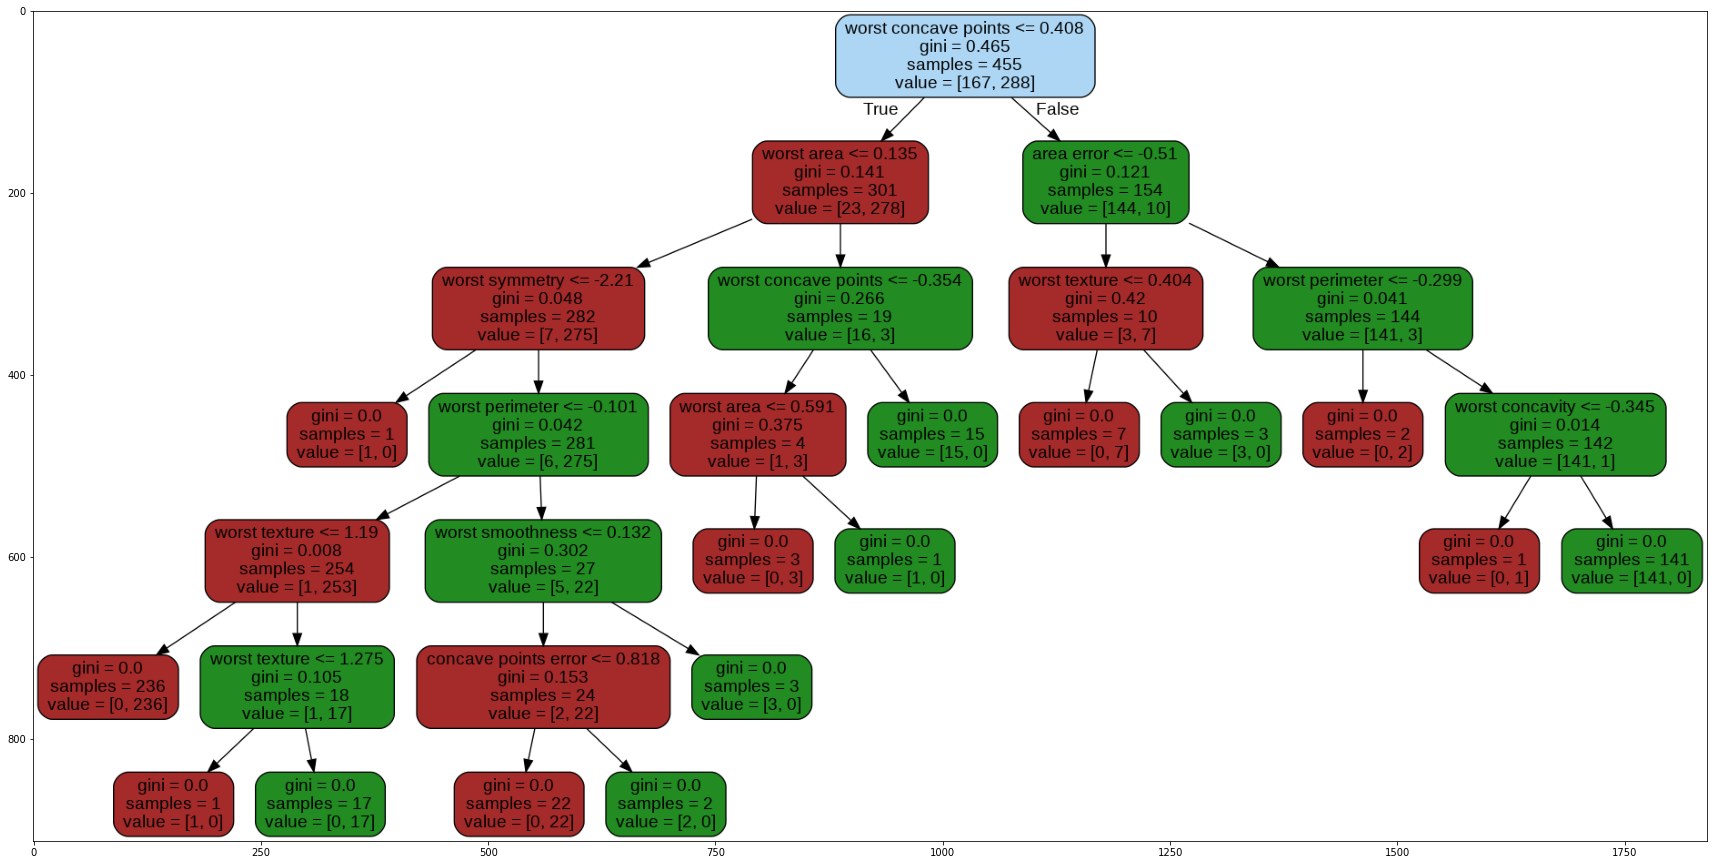

In [ ]:
dot_data = export_graphviz(DT,
                                feature_names=data.feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)

colors = ('brown', 'forestgreen')
edges = defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(2):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')
img = mpimg.imread('tree.png')
fig = plt.figure(figsize=(30,40))
plt.imshow(img)